![](TikTok.jpg)
# TikTok Video Classification Project: Random Forest and XGBoost machine learning models
*Purpose*\
TikTok is a platform for producing and viewing short-term mobile videos. Users of the platform can report videos and comments that contain claims versus opinions. With the high number of submissions and interactions on TikTok each day, it is challenging for human moderators to review efficiently each video, comment, and claim concerning content. TikTok wants to reduce the backlog of user reports and prioritize `claim` reports. **The goal of this project is to mitigate misinformation in videos on the TikTok platform by building a reliable machine learning model which will help reduce report backlog**.

* An *opinion* is a personal or group belief or thought concerning any information, action, thought, person, or group, place, or thing
* A *claim* is unqualified information concerning any information, action, thought, person, or group, place, or thing

As presented by TikTok: “any answers, responses, comments, opinions, analysis or recommendations that you are not properly licensed or otherwise qualified to provide (https://www.tiktok.com/legal/page/us/terms-of-service/en ).” \
TikTok safety: https://newsroom.tiktok.com/en-us/safety

*Deliverables*
>**Notebook Part III: Random Forest and XGBoost machine learning models**\
In Part III, the Random forest and XGBoost machine learning models are developed. For these tree-based classification models the goal is to predict a binary outcome, this time using the variable `claim_status`. Like the logistic regression model contained in Notebook II, these models produce rankings of the predictive power of each variable in estimating the `claim_status` of a video: Opinion or Claim. Although the feature `verified_status` is highly correlated with `claim_status`, confirming if it is the most predictive feature is of chief importance.

*Data*\
The data set used here comes from the Google Advanced Data Analytics Professional Certificate course on the Coursera platform: https://www.coursera.org/google-certificates/advanced-data-analytics-certificate

*Code and Reports*\
All code and reports for this project are located at: https://github.com/izsolnay/TikTok_Python

# PART III: Build and test two tree-based classification models: Random forest and XGBoost
* basic EDA
* prepare data for modelling
* build models

In [1]:
# Import standard operational packages
import numpy as np
import pandas as pd

# Import preprocessing, modeling, and evaluation packages
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

# Import from xgboost
from xgboost import XGBClassifier, plot_importance

# Import visualization package
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score, PrecisionRecallDisplay

# Save models once fitted
import pickle

# Set Jupyter to display all of the columns (no redaction)
pd.set_option('display.max_columns', None)

In [2]:
# Import data; create df
df0 = pd.read_csv('TikTok_clean.csv')
df0.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,0.056584,0.000000,0.000702
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,0.549096,0.004855,0.135111
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,0.108282,0.000365,0.003168
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,0.548459,0.001335,0.079569
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,0.622910,0.002706,0.073175


### Basic EDA revisited
* check for nulls
* check dtypes: decision trees need numeric columns, so any must be converted to ordinals
* no need to be concerned with outliers, since DTs can handle them
* encode variables

In [3]:
# Call info on new df
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19084 entries, 0 to 19083
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19084 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19084 non-null  int64  
 3   video_duration_sec        19084 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19084 non-null  object 
 6   author_ban_status         19084 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
 12  likes_per_view            19084 non-null  float64
 13  comments_per_view         19084 non-null  float64
 14  shares

In [4]:
df0.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view
count,19084.000000,1.908400e+04,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9542.500000,5.624840e+09,32.423811,254708.558688,84304.636030,16735.248323,1049.429627,349.312146,0.276093,0.000954,0.054860
std,5509.220604,2.537030e+09,16.226470,322893.280814,133420.546814,32036.174350,2004.299894,799.638865,0.173006,0.001326,0.050597
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4771.750000,3.425100e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000,0.130240,0.000098,0.014445
50%,9542.500000,5.609500e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000,0.264037,0.000455,0.039739
75%,14313.250000,7.840823e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000,0.398482,0.001268,0.081864
max,19084.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000,0.666648,0.010280,0.265956


In [5]:
# Check for missing values
print(df0.isnull().sum())
df0.shape

#                           0
claim_status                0
video_id                    0
video_duration_sec          0
video_transcription_text    0
verified_status             0
author_ban_status           0
video_view_count            0
video_like_count            0
video_share_count           0
video_download_count        0
video_comment_count         0
likes_per_view              0
comments_per_view           0
shares_per_view             0
dtype: int64


(19084, 15)

### Create new variable `text_length`

In [6]:
# Create `text_length` column
df0['text_length'] = df0['video_transcription_text'].str.len()
df0.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,0.056584,0.000000,0.000702,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,0.549096,0.004855,0.135111,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,0.108282,0.000365,0.003168,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,0.548459,0.001335,0.079569,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,0.622910,0.002706,0.073175,128


In [7]:
# Calculate median & average text length by claim_status
mean_values = df0.groupby(by='claim_status')[['text_length']].mean(numeric_only=True).round(1)
median_values = df0.groupby(by='claim_status')[['text_length']].median(numeric_only=True).round(1)

# Combine mean and median into a single DataFrame
result = mean_values.rename(columns={'claim_status': 'mean_text_length'})
result['median_text_length'] = median_values

result

,text_length,median_text_length
claim_status,,
claim,95.4,93.0
opinion,82.7,80.0


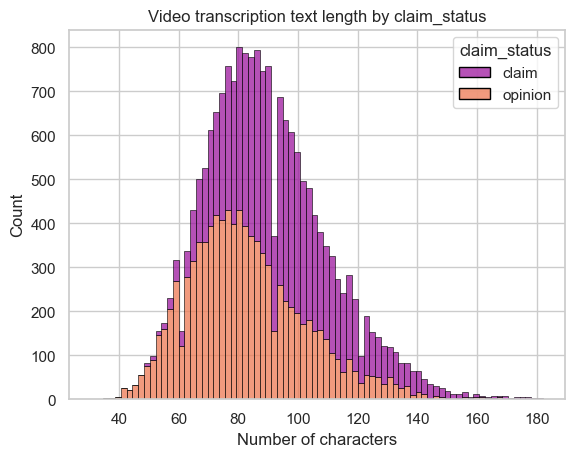

In [8]:
# Create histogram to view distribution of `video_transcription_text` length by claim_status
sns.histplot(data=df0, 
             stat='count', 
             x='text_length', 
             multiple='stack',
             palette='plasma', 
             edgecolor = 'black', 
             hue='claim_status'
            )

plt.xlabel('Number of characters')
plt.title('Video transcription text length by claim_status')

plt.show()

Results\
The results are somewhat different than the distribution of `video_transcription_text` length by `verification_status`. In that case verified authors were matched to unverified.\
The results of the distribution of `video_transcription_text` length by `claim_status`, show that Claims decidedly have longer text.

### Encode variables and feature selection
* encode `claim_status` simply using replacement
* pandas get_dummies for `verified_status` and `author_ban_status`

In [9]:
X = df0.copy()

# Encode target variable
X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})

# Dummy encode remaining categorical values
X = pd.get_dummies(X, columns=['verified_status', 'author_ban_status'], dtype=int, drop_first=True)
X.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,1,7017666017,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,0.056584,0.000000,0.000702,97,0,0,1
1,2,1,4014381136,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,0.549096,0.004855,0.135111,107,0,0,0
2,3,1,9859838091,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,0.108282,0.000365,0.003168,137,0,0,0
3,4,1,1866847991,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,0.548459,0.001335,0.079569,131,0,0,0
4,5,1,7105231098,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,0.622910,0.002706,0.073175,128,0,0,0


Results\
0 (FALSE) or 1 (TRUE)\
claim_status >
* **1 claim**
* **0 opinion**
  
author_ban_status > 
* 1/0 author_ban_status_banned
* 0/1 author_ban_status_under review
* 0/0 active

verified_status_verified > 
* 1 verified
* 0 not verified

In [10]:
# Create new csv file for modified df
X.to_csv('TikTok_for_NLP.csv', index=False)
X = pd.read_csv('TikTok_for_NLP.csv')
X.head(2)

,#,claim_status,video_id,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,1,7017666017,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,0.056584,0.000000,0.000702,97,0,0,1
1,2,1,4014381136,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,0.549096,0.004855,0.135111,107,0,0,0


In [11]:
# Drop unnecessary columns
X = X.drop(columns=['#', 'video_id', 'video_transcription_text'])

## Prepare data for modelling
* choose evaluation metric: recall, because the goal is to identify Claims videos
* no need to check for multicollinearity - DTs can handle them

Split the data into:
* features and target variable
* training data(80%) and test data(20%)
* split separate validation data
  * set 75/25 into a training set and a validation set to get 75% of 80%
* set a random seed so work can be reproduced (0)

In [12]:
# Check class balance for target variable `claim_status`
print(X['claim_status'].value_counts())
print(X['claim_status'].value_counts(normalize=True))

claim_status
1    9608
0    9476
Name: count, dtype: int64
claim_status
1    0.503458
0    0.496542
Name: proportion, dtype: float64


Result\
No need to stratify, because values are balanced.

In [13]:
# Subset data into dependent y(target) and independent X variables
y = X['claim_status']
X = X.drop(columns=['claim_status'])

In [14]:
# Verify # and dtype of samples for in the partitioned data
print('X')
print(X.info())
print('y')
print(y.info())

X
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19084 entries, 0 to 19083
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   video_duration_sec              19084 non-null  int64  
 1   video_view_count                19084 non-null  float64
 2   video_like_count                19084 non-null  float64
 3   video_share_count               19084 non-null  float64
 4   video_download_count            19084 non-null  float64
 5   video_comment_count             19084 non-null  float64
 6   likes_per_view                  19084 non-null  float64
 7   comments_per_view               19084 non-null  float64
 8   shares_per_view                 19084 non-null  float64
 9   text_length                     19084 non-null  int64  
 10  verified_status_verified        19084 non-null  int64  
 11  author_ban_status_banned        19084 non-null  int64  
 12  author_ban_status_under review

In [15]:
# Split into train and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)

In [16]:
# Get balances of each training, validation, and testing sets
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 13), (3817, 13), (3817, 13), (11450,), (3817,), (3817,))

This aligns with expectations.

## PART IIIa: build random forest model
* instantiate RF model
* define and tune hyperparameters
* define scoring criteria: use recall as metric
* construct GridSearch cross-validation
* fit model to training data

In [17]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# Determine set of hyperparameters
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
             'max_samples': [0.7],
             'min_samples_leaf': [1, 2],
             'min_samples_split': [2, 3],
             'n_estimators': [75, 100, 200],
             }

# Define scoring criteria
scoring = ['accuracy', 'precision', 'recall', 'f1']

In [18]:
# Instantiate the GridSearchCV object
# refit: use recall as metric
RF_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [19]:
# Fit model to the training data & call magic function time to time execution
%time
RF_cv.fit(X_train, y_train)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [20]:
# Examine best average score across all the validation folds
RF_cv.best_score_

0.9924066515562668

In [21]:
# Examine best combination of hyperparameters
RF_cv.best_params_

{'max_depth': 5,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 75}

In [22]:
# Create a metrics results table which returns a df with metrics for model with the best mean 'metric' score across all validation folds (cvs)

def model_results(model_name:str, model_object, metric:str):  # model_name: name, model_object: a fit GridSearchCV object, metric:str
    
    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }
    
    TT_cv_results = pd.DataFrame(model_object.cv_results_) # Create df for all results
    
    best_estimator_results = TT_cv_results.iloc[TT_cv_results[metric_dict[metric]].idxmax(), :] # idxmax() returns a series with the index of the max value for each col
    
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

# Create table of best estimator row results
    table = pd.DataFrame({'Model': [model_name],
                          'Precision': [precision],
                          'Recall': [recall],
                          'Accuracy': [accuracy],
                          'F1': [f1]
                         },)
    return table

In [23]:
# Pass the GridSearch object to the model_results() function
# Specify metric: recall score
TT_RF_cv_results = model_results('Random Forest cv', RF_cv, 'recall')
TT_RF_cv_results

,Model,Precision,Recall,Accuracy,F1
0,Random Forest cv,0.999825,0.992407,0.99607,0.9961


In [24]:
# Save results table as csv
TT_RF_cv_results.to_csv('Claims_Results.csv', index = False) # index = False to remove indexing row

In [25]:
# Read in master results table
TikTok_models = pd.read_csv('Claims_Results.csv')
TikTok_models

,Model,Precision,Recall,Accuracy,F1
0,Random Forest cv,0.999825,0.992407,0.99607,0.9961


#### Pickle the model (save)

In [26]:
# Pickle the model
with open('RF_cv_TikTok.pickle', 'wb') as to_write: # wb = write binary
    pickle.dump(RF_cv, to_write)

In [27]:
# Read in pickled model
with open('RF_cv_TikTok.pickle', 'rb') as to_read: # rb = read binary
    RF_cv = pickle.load(to_read)

## Part IIIb: build an XGBoost model
* instantiate XGBoost model
  * set random_state to 42 
* define and tune hyperparameters
* define scoring criteria: use recall as metric
* construct GridSearch cross-validation
* fit model to training data

In [28]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# Determine set of hyperparameters
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Define scoring criteria
scoring = ['accuracy', 'precision', 'recall', 'f1']

In [29]:
# Instantiate the GridSearchCV object
# refit: use recall as metric
XGB_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [30]:
# Fit the model to the X_train and y_train data 
%time
XGB_cv.fit(X_train, y_train)

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 8.11 µs


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [31]:
# Examine best score
XGB_cv.best_score_

0.9913708291794634

In [32]:
# Examine best parameters
XGB_cv.best_params_

{'learning_rate': 0.01,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 300}

In [33]:
# Pass the GridSearch object to the model_results() function
TT_XGB_cv_results = model_results('XGBoost cv', XGB_cv, 'recall')
TT_XGB_cv_results

,Model,Precision,Recall,Accuracy,F1
0,XGBoost cv,0.999825,0.991371,0.995546,0.995578


In [34]:
# Concatenate model results table with master results table
TikTok_models = pd.concat([TikTok_models, TT_XGB_cv_results])
TikTok_models

,Model,Precision,Recall,Accuracy,F1
0,Random Forest cv,0.999825,0.992407,0.996070,0.996100
0,XGBoost cv,0.999825,0.991371,0.995546,0.995578


In [35]:
# Save the master results table
TikTok_models.to_csv('Claims_Results.csv', index=False);

In [36]:
# View the results
TikTok_models = pd.read_csv('Claims_Results.csv')
TikTok_models = TikTok_models.sort_values(by=['Recall'], ascending=False)
TikTok_models.head()

,Model,Precision,Recall,Accuracy,F1
0,Random Forest cv,0.999825,0.992407,0.996070,0.996100
1,XGBoost cv,0.999825,0.991371,0.995546,0.995578


#### Pickle the model (save)

In [37]:
# Pickle the model
with open('XGB_cv_TikTok.pickle', 'wb') as to_write: # wb = write binary
    pickle.dump(XGB_cv, to_write)

In [38]:
# Read in pickled model
with open('XGB_cv_TikTok.pickle', 'rb') as to_read: # rb = read binary
    XGB_cv = pickle.load(to_read)

### Use models with validation set
* Random forest model
* XGBoost model

#### Random forest model on validation set

In [39]:
# Use random forest model to predict on validation data with best tree
RF_val_preds = RF_cv.best_estimator_.predict(X_val)

In [40]:
# Create classification report for random forest model
target_labels = ['Opinion', 'Claim']
print(classification_report(y_val, RF_val_preds, target_names=target_labels))

              precision    recall  f1-score   support

     Opinion       0.99      1.00      1.00      1892
       Claim       1.00      0.99      1.00      1925

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



In [41]:
# Create get_val_scores funtion to create a table with validation data scores

def get_val_scores(model_name:str, preds, y_val_data):

    accuracy = accuracy_score(y_val_data, preds)
    precision = precision_score(y_val_data, preds)
    recall = recall_score(y_val_data, preds)
    f1 = f1_score(y_val_data, preds)
    
# Create df table 
    table = pd.DataFrame({'Model': [model_name],
                          'Precision': [precision],
                          'Recall': [recall],
                          'Accuracy': [accuracy],
                          'F1': [f1]
                          },)

    return table

In [42]:
# Pass the scores get_val_scores function
RF_val = get_val_scores('Random Forest val', RF_val_preds, y_val)
RF_val

,Model,Precision,Recall,Accuracy,F1
0,Random Forest val,1.0,0.991169,0.995546,0.995565


In [43]:
# Concatenate model validation set results table with master results table
TikTok_models = pd.concat([TikTok_models, RF_val])
TikTok_models

,Model,Precision,Recall,Accuracy,F1
0,Random Forest cv,0.999825,0.992407,0.996070,0.996100
1,XGBoost cv,0.999825,0.991371,0.995546,0.995578
0,Random Forest val,1.000000,0.991169,0.995546,0.995565


In [44]:
# Save the master results table
TikTok_models.to_csv('Claims_Results.csv', index=False);

#### XGBoost model on validation set

In [45]:
# Use XGBoost model to predict on validation data with best tree
XGB_val_preds = XGB_cv.best_estimator_.predict(X_val)

In [46]:
# Create classification report for XGBoost model
target_labels = ['Opinion', 'Claim']
print(classification_report(y_val, XGB_val_preds, target_names=target_labels))

              precision    recall  f1-score   support

     Opinion       0.99      1.00      1.00      1892
       Claim       1.00      0.99      1.00      1925

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



In [47]:
# Pass the scores get_val_scores function 
XGB_val = get_val_scores('XGBoost val', XGB_val_preds, y_val)
XGB_val

,Model,Precision,Recall,Accuracy,F1
0,XGBoost val,1.0,0.991688,0.995808,0.995827


In [48]:
# Concatenate model validation set table with master results table
TikTok_models = pd.concat([TikTok_models, XGB_val])

In [49]:
# Save the master results table
TikTok_models.to_csv('Claims_Results.csv', index=False);

In [50]:
# View the results
TikTok_models = pd.read_csv('Claims_Results.csv')
TikTok_models = TikTok_models.sort_values(by=['Recall'], ascending=False)
TikTok_models.head()

,Model,Precision,Recall,Accuracy,F1
0,Random Forest cv,0.999825,0.992407,0.996070,0.996100
3,XGBoost val,1.000000,0.991688,0.995808,0.995827
1,XGBoost cv,0.999825,0.991371,0.995546,0.995578
2,Random Forest val,1.000000,0.991169,0.995546,0.995565


#### Results
These models are neck and neck. The random forest model performed slightly better with validation folds, however the XGBoost model performed better on the unseen validation data.\
The XGBoost model wins.

## Use best model on test data
The above table shows, when refitted to Recall, the XGB Boost model performed better than the random forest model on the unseen validation data set.\
It will be used on the test data.

In [51]:
# Use XGBoost model to predict on test data with best tree
XGB_test_preds = XGB_cv.best_estimator_.predict(X_test)

In [52]:
# Create get_test_scores funtion to create a table with test scores

def get_test_scores(model_name:str, preds, y_test_data):   # model_name: name, preds: predictions, y_test_data: y_test data

    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)
    
# Create table of best estimator row results
    table = pd.DataFrame({'Model': [model_name],
                          'Precision': [precision],
                          'Recall': [recall],
                          'Accuracy': [accuracy],
                          'F1': [f1]
                          },)

    return table

In [53]:
# Pass the scores get_test_scores function.
XGB_test = get_test_scores('XGBoost TEST', XGB_test_preds, y_test)
XGB_test

,Model,Precision,Recall,Accuracy,F1
0,XGBoost TEST,1.0,0.994177,0.997118,0.99708


In [54]:
# Concatenate XGBoost tested model results table with master results table
TikTok_models = pd.concat([TikTok_models, XGB_test])

In [55]:
# Save the master results table
TikTok_models.to_csv('Claims_Results.csv', index=False);

In [56]:
# View the results
TikTok_models = pd.read_csv('Claims_Results.csv')
TikTok_models = TikTok_models.sort_values(by=['Recall'], ascending=False)
TikTok_models.head()

,Model,Precision,Recall,Accuracy,F1
4,XGBoost TEST,1.000000,0.994177,0.997118,0.997080
0,Random Forest cv,0.999825,0.992407,0.996070,0.996100
1,XGBoost val,1.000000,0.991688,0.995808,0.995827
2,XGBoost cv,0.999825,0.991371,0.995546,0.995578
3,Random Forest val,1.000000,0.991169,0.995546,0.995565


In [57]:
# Create a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_test, XGB_test_preds, target_names = target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      1.00      1928
       claim       1.00      0.99      1.00      1889

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



#### Results
Surprisingly, when the XGBoost model was fitted to the test data, it actually performed better than on the training data.

### Visualizations and evaluations on tested XGBoost classification model
* plot a confusion matrix
* plot ROC curve
* compute AUC
* plot precision-recall curve
* get best features

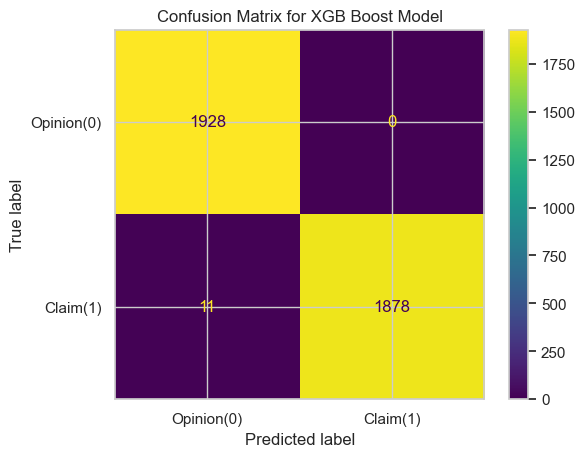

In [58]:
# Create confusion matrix to visualize how accurate classifier is at predicting the labels for a categorical variable
cm = confusion_matrix(y_test, XGB_test_preds, labels=XGB_cv.classes_)

# Visualize confusion matrix
XGB_disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Opinion(0)', 'Claim(1)'])
XGB_disp.plot()
plt.title('Confusion Matrix for XGB Boost Model');

In [59]:
# Get shape of testing set
X_test.shape, y_test.shape

((3817, 13), (3817,))

*Legend*
* True label (y_test): actual labels of the holdout sample
* Predicted label (y_pred): predicted labels (Opinion videos/Claims video) on the holdout test sample

Since this is a binomial classification, there are only two labels:
* 0 = the video was labeled as an opinion video for that observation
* 1 = the video was labeled as a claim video for that observation

*Translation*<br>
`True negatives`(UL): # of Opinion videos(0) that the model accurately predicted as Opinions(0) = 1928   
`True positives`(LR): # of Claims videos(1) that the model accurately predicted Claims(1) = 1878   
`False positives`(UR)/Type I Errors: # of Opinion videos(0) that the model predicted were Claims(1) = 0   
`False negatives`(LL)/Type II Errors: # of Claims videos(1) that the model predicted were Opinions(0) = 11   

Immediately seen from the confusion matrix is that this model has superior performance

#### Plot ROC and AOC

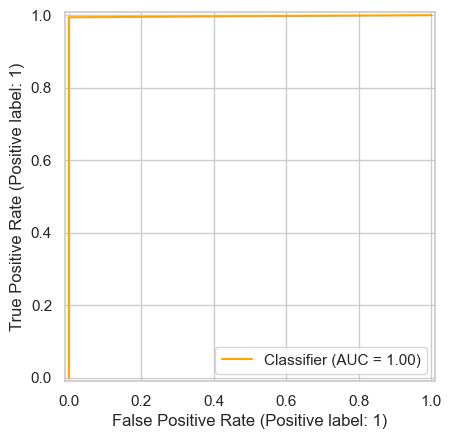

In [60]:
# Plot ROC curve
RocCurveDisplay.from_predictions(y_test, XGB_test_preds, color ='orange')
plt.show()

In [61]:
# Compute the AUC
print('roc_auc_score:', roc_auc_score(y_test, XGB_test_preds))

roc_auc_score: 0.9970884065643197


Results    
The champion XGBoost model performed strongly with near perfect classifications across all possible classification thresholds (classification decisions). 

With an AUC score of 100%, it could likely not perform better.

#### Plot precision-recall curve

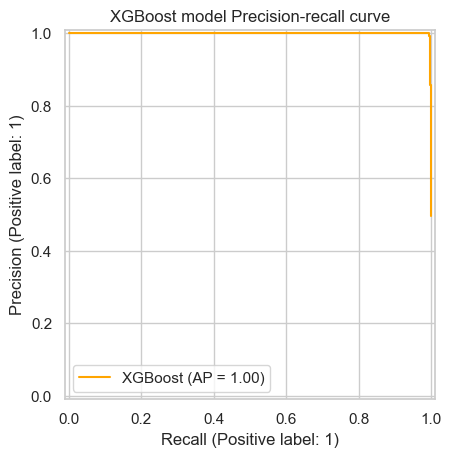

In [62]:
# Compute precision-recall pairs for different probability thresholds
display = PrecisionRecallDisplay.from_estimator(XGB_cv.best_estimator_, X_test, y_test, name='XGBoost', color ='orange')
plt.title('XGBoost model Precision-recall curve');

Results    
Precision is a metric that quantifies the number of correct positive predictions made. \
Recall is a metric that quantifies the number of correct positive predictions made out of all positive predictions that could have been made.

As recall increases, precision decreases. 

The precision-recall curve plots precision (y-axis) and recall (x-axis) for different probability thresholds. In a balanced dataset this is at 50% by default. 

The essentially perfect precision curve confirms the "high" rating of the ROC curve.

#### Plot feature importance

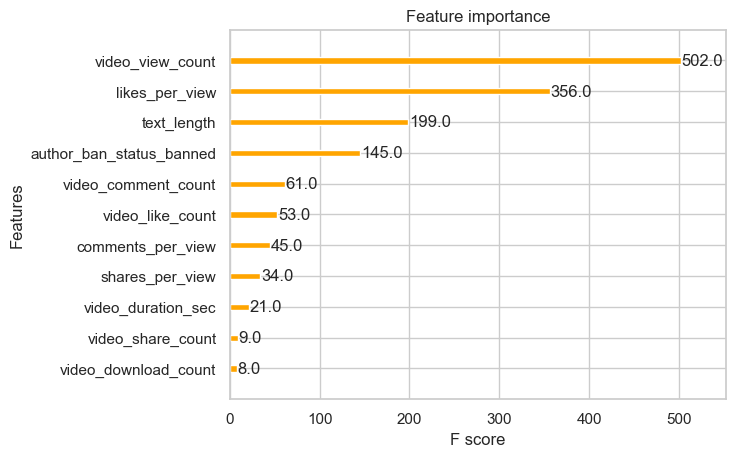

In [63]:
plot_importance(XGB_cv.best_estimator_, color ='orange')
plt.show()

#### Results    
According to the feature importance plot, `video_view_count` was hands down the most predictive feature. The created feature `like_per_view` was second in power.

The created feature  `text_length` and categorical feature `author_ban_status_banned` were next most important.
* So, knowing if the author of the video was banned or if the video was longer was predictive.
  
`video_download_count` and `video_share_count` had little to no impact on predictability. This is interesting, because the EDA revealed both their means to be significant between the categories Claim and Opinion.

## See TikTok Executive Summary III for summary